In [77]:
import ROOT
import csv 
import numpy as np
import matplotlib.pyplot as plt
import uproot
import astropy.io.fits as fits
import cv2
print("Done!")

Done!


In [78]:
import pandas as pd

# Read Data

In [79]:
# ubicación de los archivos de entrada y salida
root_folder = r'../'
fits_folder = 'datos_fits/'
png_folder = 'datos_png_2/'
filename = 'MuonsConnie_10000.root'
# lee el archivo root
file = uproot.open(root_folder+filename)
#file.keys()

In [80]:
# extrae los árboles del archivo root
ccd_trees = {}
for key in file.keys():
    name = key.split(";")[0]
    
    # descarta las llaves que no sean de muones
    if 'muonCCD' not in name:
        continue
    
    # almacena el primer árbol para cada CCD
    if name not in ccd_trees.keys():
        ccd_trees[name] = key;

list(ccd_trees.values())

['muonCCD1;27',
 'muonCCD2;25',
 'muonCCD3;23',
 'muonCCD4;22',
 'muonCCD5;20',
 'muonCCD6;18',
 'muonCCD7;17',
 'muonCCD8;16',
 'muonCCD9;15',
 'muonCCD10;14']

# Histograma

In [81]:
def generate_hist(ccd):
    
    # extrae las posiciones de cada punto
    diffX = np.array(ccd['DiffX'])
    print(diffX)
    diffY = np.array(ccd['DiffY'])
    
    MPP= 2 #(Micrones per Pixel)
    #min_X ,max_X= int(min(diffX)), int(max(diffX))
    #min_Y ,max_Y= int(min(diffY)), int(max(diffY))

    #binx = int((max_X-min_X) / MPP)
    #biny = int((max_Y-min_Y) / MPP)

    # genera los intervalos del histograma
    #edgesX = np.linspace(min_X, max_X, binx, endpoint=True)
    #edgesY = np.linspace(min_Y, max_Y, biny, endpoint=True)
    
    # genera los intervalos del histograma
    edgesX = np.linspace(-30000, 30000, 4006, endpoint=True)
    edgesY = np.linspace(-34055, 26056, 4007, endpoint=True)
    
    # calcula el histograma
    hist, _, _ = np.histogram2d(diffX, diffY, bins=(edgesX,edgesY), density=False)
    return np.array(hist)

In [6]:
def edges(ccd):
    min_X ,max_X= min(np.array(ccd['DiffX'])), max(np.array(ccd['DiffX']))
    min_Y ,max_Y= min(np.array(ccd['DiffY'])), max(np.array(ccd['DiffY']))
    return [min_X ,max_X,min_Y ,max_Y]

In [ ]:
cont=0
for name, key in ccd_trees.items():
    if cont==0:
        bordes = edges(file[key])
    cont+=1

In [ ]:
diferenciaX = bordes[1]-bordes[0]
diferenciaY = bordes[3]-bordes[2]

In [ ]:
diferenciaY/15

In [ ]:
print(bordes[2],bordes[3],diferenciaY,diferenciaY/15)

In [8]:
# especifica los formatos de salida
save_as_png       = True
save_as_fits      = False
save_as_fits_cube = False

In [9]:
%%time
hdul = fits.HDUList()
cmap = plt.cm.viridis

# por cada CCD seleccionado
for name, key in ccd_trees.items():
    
    # genera el histograma
    img = generate_hist(file[key])
    img = np.log(img, out=np.zeros_like(img), where=(img!=0))
    
    # guarda el histograma como imagen png
    if save_as_png:
        norm = plt.Normalize(vmin=img.min(), vmax=img.max())
        ccd_png = png_folder+name+'.png'
        plt.imsave(ccd_png, cmap(norm(img)))
        print(name+'\t->\t'+ccd_png)
    
    # construye un hdu a partir del histograma
    if save_as_fits or save_as_fits_cube:
        hdu = fits.ImageHDU(img, name=name)
    else:
        continue
    
    # exporta el hdu a un archivo fits
    if save_as_fits:
        ccd_fits = fits_folder+name+'.fits'
        hdu.writeto(ccd_fits, overwrite=True)
        print(name+'\t->\t'+ccd_fits)
    
    # almacena el hdu para generar el cubo
    if save_as_fits_cube:
        hdul.append(hdu)
        print(name+'\t->\t'+'[HDUList]')

# exporta los hdu almacenados a un cubo fits
if save_as_fits_cube:
    filename_fits = fits_folder+filename+'.fits'
    hdul.writeto(filename_fits, overwrite=True)
    print('[HDUList]\t->\t'+filename_fits)

# fin
print('Done')
print()

[ 15826.04851696  15819.8450635   15822.4514433  ... -29419.05461069
 -29418.34203629 -29431.24702993]
muonCCD1	->	datos_png_2/muonCCD1.png
[           nan            nan            nan ... 10138.14217112
 10136.32381952 10146.68204242]
muonCCD2	->	datos_png_2/muonCCD2.png
[           nan            nan            nan ... 11933.75583844
 11941.32343716 11968.88867633]
muonCCD3	->	datos_png_2/muonCCD3.png
[14994.87156868 14995.24039693 14996.36370237 ... 13748.08674988
 13703.30836477 13701.87248353]
muonCCD4	->	datos_png_2/muonCCD4.png
[14720.39317609 14719.31198001 14722.9610977  ... 15509.38434661
 15479.81017544 15531.14921636]
muonCCD5	->	datos_png_2/muonCCD5.png
[14445.67601762 14445.04044574 14447.18554842 ... 17298.98352122
 17285.29429909 17272.3980652 ]
muonCCD6	->	datos_png_2/muonCCD6.png
[           nan            nan            nan ... 19043.20287985
 19037.12793854 19093.2443025 ]
muonCCD7	->	datos_png_2/muonCCD7.png
[13894.01842982 13898.33414586 13898.91416566 ... 20860.

# Segmentacion

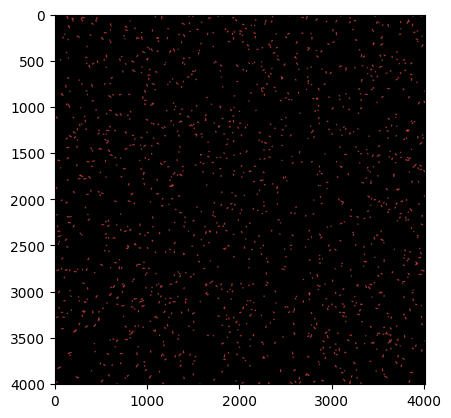

In [24]:
# Cargar la imagen
image = cv2.imread('./datos_png_2/muonCCD1.png')

# Convertir la imagen a escala de grises
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Aplicar umbralización para obtener una imagen binaria
_, binary_image = cv2.threshold(gray_image, 30, 255, cv2.THRESH_BINARY)

# Encontrar contornos en la imagen binaria
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Crear una imagen en blanco del mismo tamaño que la imagen original
segmented_image = np.zeros_like(image)

# Dibujar los contornos en rojo y rellenar el interior con blanco
for contour in contours:
    cv2.drawContours(segmented_image, [contour], -1, (255, 255, 255), 2)
    cv2.fillPoly(segmented_image, [contour], (0, 0, 255))
    #cv2.fillPoly(segmented_image, [contour], (255, 255, 255))
# Mostrar la imagen segmentada
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.axis('on')
plt.show()

In [25]:
cv2.imwrite('imagen_segmentada_ccd1_vf.png', segmented_image)

True

In [72]:
def TransformarCoordenadas(image,centroide):
    height, width, _ = image.shape
    center_x = int(width / 2)
    center_y = int(height / 2)
    #print("Centro ",center_x," ",center_y)
    new_x = ( centroide[0] - center_x ) *15
    new_y = ( centroide[1] - center_y ) * 15
    return new_x, new_y
contornos=[]
df = pd.DataFrame(
    columns=["X_C", "Y_C","X_size","Y_size"]
)
for contour in contours:
    # Calcular los momentos del contorno
    moments = cv2.moments(contour)
    
    # Verificar si el momento m00 es mayor que cero para evitar la división por cero
    if moments['m00'] != 0:
        # Calcular las coordenadas del centroide
        centroid_x = int(moments['m10'] / moments['m00'])
        centroid_y = int(moments['m01'] / moments['m00'])
        
        # Imprimir las coordenadas del centroide
        centroid_x,centroid_y = TransformarCoordenadas(segmented_image,[centroid_x, centroid_y])
        # Obtener el rectángulo delimitador
        x, y, width, height = cv2.boundingRect(contour)
        # Mostrar el tamaño del evento segmentado
        #print("Ancho:", width)
        #print("Altura:", height)
        nueva_fila = [centroid_x, centroid_y,15*width,15*height]
        df.loc[len(df)] = nueva_fila
        #print("Centroide: ({}, {}) Tamaño de la ventana ({}, {})  ".format(centroid_x, centroid_y,width*15,height*15))
        contornos.append([centroid_x, centroid_y])

    #index+=1

In [73]:
display(df)

,X_C,Y_C,X_size,Y_size
0,7905,30015,75,45
1,-6525,30000,120,75
2,-19980,29985,150,120
3,315,29955,90,165
4,8415,29955,225,180
...,...,...,...,...
1401,4230,-30015,75,75
1402,450,-29985,90,135
1403,-9330,-29940,120,255
1404,-13905,-29805,495,555


In [82]:
filas_filtradas = (df[(df["X_C"] >= 14000) & (df["X_C"] <= 16000) ]).sort_values('X_C')

In [83]:
display(filas_filtradas)

,X_C,Y_C,X_size,Y_size
322,14010,16185,210,165
1365,14040,-28845,150,210
176,14070,21645,165,225
726,14100,-1680,150,165
742,14175,-2715,315,150
588,14175,4560,165,165
1005,14205,-12600,195,210
271,14235,17865,195,360
156,14235,22365,225,480
1279,14325,-25185,315,225


In [58]:
len(contours)

1443

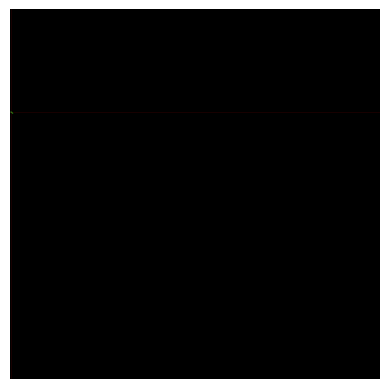

In [64]:
indice_contorno = 1049

# Calcular el centroide del contorno específico
contour = contours[indice_contorno]
M = cv2.moments(contour)
centroid_x = int(M['m10'] / M['m00'])
centroid_y = int(M['m01'] / M['m00'])

# Crear una imagen en blanco del mismo tamaño que la imagen original
segmented_image = np.zeros_like(image)

# Dibujar el contorno específico en verde y rellenar su contenido con blanco
cv2.drawContours(segmented_image, contours, indice_contorno, (0, 255, 0), 2)
cv2.fillPoly(segmented_image, contours[indice_contorno], (255, 255, 255))

# Dibujar los ejes horizontal y vertical en rojo
cv2.line(segmented_image, (0, centroid_y), (image.shape[1], centroid_y), (0, 0, 255), 1)
cv2.line(segmented_image, (centroid_x, 0), (centroid_x, image.shape[0]), (0, 0, 255), 1)

# Mostrar la imagen segmentada con los ejes
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [65]:
cv2.imwrite('imagen_segmentada_ccd1_1049.png', segmented_image)

True